In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from os import path
from utils import plot_report

import pandas as pd
%matplotlib inline

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np

import config

In [2]:
# training parameters
seed= config.seed

dr=0.25
lr2=1e-3
lr1=1e-4
lr=8e-4

num_epochs=5000
mini_batch_size=4

main_units=64
secondary_units=16
last_unit=8
lstm_units=64
num_classes=1

# radius or residues
feature='radius'

# if features is residues ''<coefficients>_' for example '17_' otherwhise ''
coefficients= '' if feature == 'radius' else '17_'

print_sample=False
normalize=True

tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
score = 'accuracy'

#this data has been previously processed by airflow
features = pd.read_csv("/data/elekin/data/results/handwriting/tmp/{}_{}20220911.csv".format(feature, coefficients)) #TODO automate
features = features.set_index(features.columns[0]).T.sort_index()
print("Loaded data from CSV")
features.sample(5)

Loaded data from CSV


Unnamed: 0,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
C107_2,0.0,355.624075,135.638193,24.976693,113.897150,93.545709,567.438441,1798.279530,2935.076736,3349.572671,...,3991.294898,4130.069025,3912.524597,3554.376996,3528.579667,3995.376782,4479.075345,4231.423738,2977.290141,1263.206580
C02_2,0.0,173.566930,12.538338,98.870983,6.796911,54.299251,28.669934,67.275333,19.184871,21.175951,...,1308.708234,1245.064585,1272.218708,1352.816851,1310.048849,1198.136660,1270.206040,1460.402804,1314.015097,665.423711
T029,0.0,228.383101,1322.805304,1797.111744,1607.715313,1699.787983,1669.943828,1691.439960,1753.793388,1752.056838,...,2064.621201,2110.436571,2080.912561,2100.225198,2113.985257,2061.646224,2167.126687,2000.823064,2249.651577,1902.070097
C103_1,0.0,668.404398,401.443445,122.336849,227.183895,362.351360,632.993986,743.839306,1281.616129,1487.843794,...,5851.132290,6120.113040,6094.173641,5769.197743,6131.354844,6221.274537,5576.521683,6146.007245,6777.540342,3990.142277
T027,0.0,127.925597,120.207266,23.904619,30.814284,85.547224,34.126320,22.763058,72.948388,34.594421,...,1250.045157,1268.204978,1328.028161,1252.089036,1288.005817,1379.227446,1242.374997,1320.712660,1541.756593,953.877780


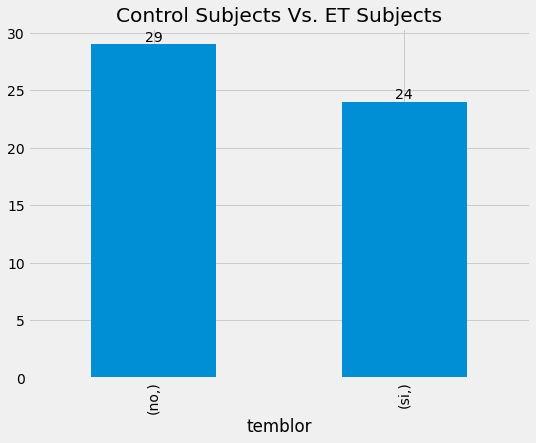

In [4]:
labels = pd.read_csv("/data/elekin/data/results/handwriting/binary_labels_20220903.csv", index_col=0).sort_index()
ax = labels.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

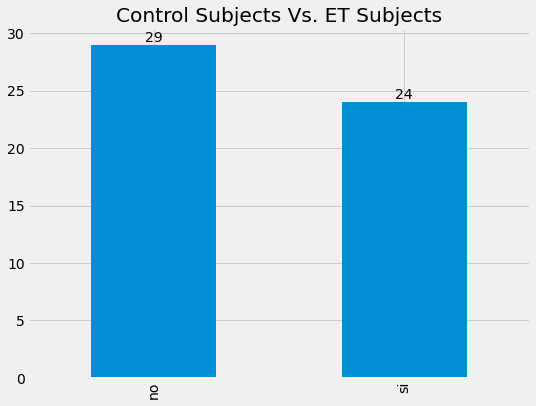

In [5]:
labels.columns = ['labels']
labels = features.join(labels).labels
ax = labels.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

In [6]:
np.array_equal(features.index.unique().values, labels.index.values)

True

In [7]:
from sklearn import preprocessing
#lb = preprocessing.LabelBinarizer()
#y = lb.fit_transform(labels).astype(np.int16)
#y.shape
#binary labels
le = LabelEncoder().fit(labels.values.ravel())
y = le.fit_transform(labels.values.ravel()).astype(np.int16)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int16)

In [8]:
X=features.values.astype(np.float64)
X.shape

(53, 4096)

In [9]:
scaler = MinMaxScaler()
print(scaler.fit(X))
print(scaler.data_max_)
#print(scaler.mean_)
print(scaler.transform(X))

MinMaxScaler()
[   0.         1371.16571794 3938.46800727 ... 6611.16220004 6777.5403416
 4997.8457149 ]
[[0.         0.07982281 0.00302512 ... 0.0584983  0.03160606 0.03526998]
 [0.         0.10822861 0.         ... 0.11494715 0.08453906 0.07072379]
 [0.         0.09888193 0.01897245 ... 0.0854721  0.0315158  0.02881741]
 ...
 [0.         0.25041419 0.37067958 ... 0.73743403 0.85719899 0.97513719]
 [0.         0.05324481 0.02075691 ... 0.07114234 0.         0.        ]
 [0.         0.14614354 0.33580221 ... 0.2049907  0.24341224 0.3384946 ]]


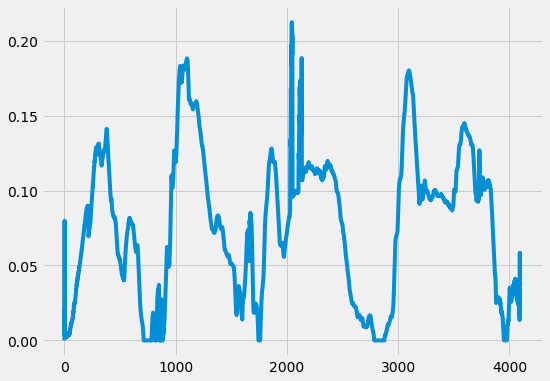

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)
if normalize:
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
plt.plot(x_train[10,:])

In [11]:
x_train.shape, x_test.shape

((35, 4096), (18, 4096))

In [12]:
#train_mean = x_train.mean()
#train_std = x_train.std()

#x_train = (x_train - train_mean) / train_std
#x_test = (x_test - train_mean) / train_std
#plt.plot(x_train[10,:])

In [13]:
num_features = x_train.shape[1]

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

9 train batches and 5 test batches of 4 mini batch size and 2 steps per epoch


## FCNN ARCHITECTURE ANALISYS

Some training helpers functions

In [15]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-4),
      ]

def compile_and_fit(model, train_dataset, test_dataset, optimizer=None, max_epochs=1000, loss='categorical_crossentropy'):
    
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.summary()
   
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(),
                        verbose=1, shuffle=False)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [16]:
size_histories = {}

In [17]:
inputs = tf.keras.Input(shape=(num_features,))

dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_1)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_histories['fcnn/tiny/sgd'] = compile_and_fit(model, train_dataset, 
                                              test_dataset,
#                                              optimizer=tf.keras.optimizers.Adam(lr), 
                                              optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
                                              max_epochs=num_epochs,
                                              loss='binary_crossentropy')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 262,273
Trainable params: 262,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
9/9 [==============================] - 1s 12ms/step - loss: 0.7476 - accuracy: 0.4000 - val_loss: 0.6759 - val_accuracy: 0.6111
Epoch 2/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.7291 - accuracy: 0.3714 - val_loss: 0.6801 - val_accuracy: 0.5556
Epoch 3/5000
9/9 [====================

In [18]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 965us/step - loss: 0.2033 - accuracy: 0.9714
training loss : 0.2032707929611206
training accuracy : 0.9714285731315613
5/5 [==============================] - 0s 1ms/step - loss: 1.0740 - accuracy: 0.6111
test loss : 1.0740022659301758
test accuracy : 0.6111111044883728


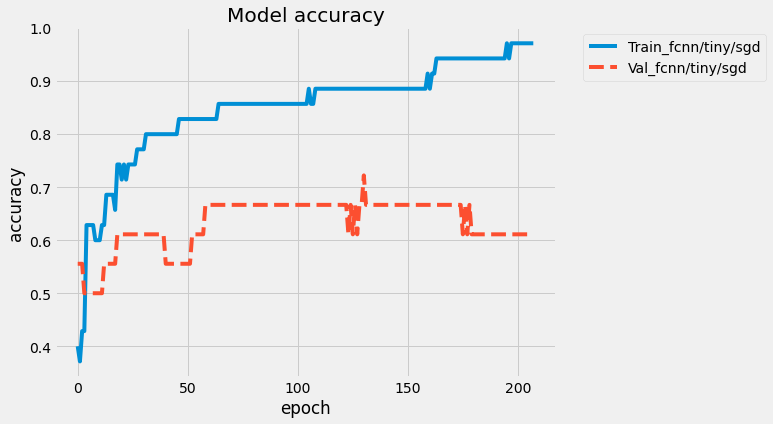

In [19]:
plot_report(size_histories, metric='accuracy')

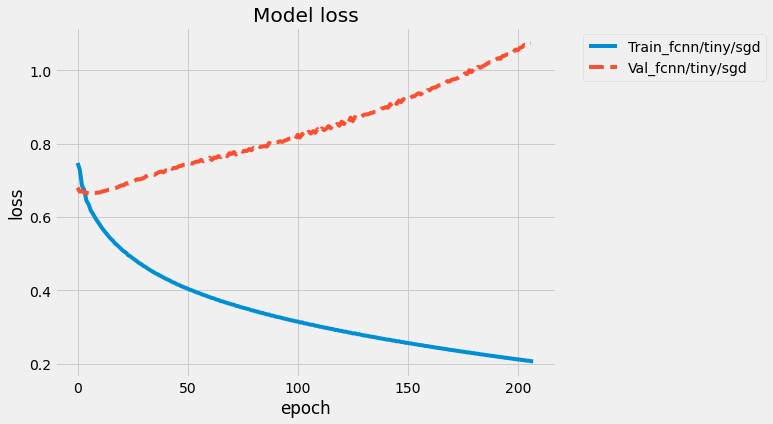

In [20]:
plot_report(size_histories, 'loss')

In [21]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu)(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu)(dense_1)
outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_2)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_histories['fcnn/small/sgd'] = compile_and_fit(model, train_dataset, 
                                              test_dataset,loss='binary_crossentropy',
                                              optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 263,265
Trainable params: 263,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


9/9 [==============================] - 0s 11ms/step - loss: 0.7080 - accuracy: 0.4286 - val_loss: 0.6960 - val_accuracy: 0.4444
Epoch 2/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.6286 - val_loss: 0.6802 - val_accuracy: 0.5556
Epoch 3/5000
9/9 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.6000 - val_loss: 0.6901 - val_accuracy: 0.5556
Epoch 4/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6673 - accuracy: 0.6000 - val_loss: 0.6835 - val_accuracy: 0.6111
Epoch 5/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6603 - accuracy: 0.6000 - val_loss: 0.6831 - val_accuracy: 0.6111
Epoch 6/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6529 - accuracy: 0.6857 - val_loss: 0.6851 - val_accuracy: 0.5000
Epoch 7/5000
9/9 [==============================] - 0s 2ms/step - loss: 0.6472 - accuracy: 0.6286 - val_loss: 0.6819 - val_accuracy: 0.6111
Epoch 8/5000
9/9 [==============

In [22]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 1ms/step - loss: 0.0870 - accuracy: 0.9714
training loss : 0.08699677884578705
training accuracy : 0.9714285731315613
5/5 [==============================] - 0s 1ms/step - loss: 1.7422 - accuracy: 0.6667
test loss : 1.7421841621398926
test accuracy : 0.6666666865348816


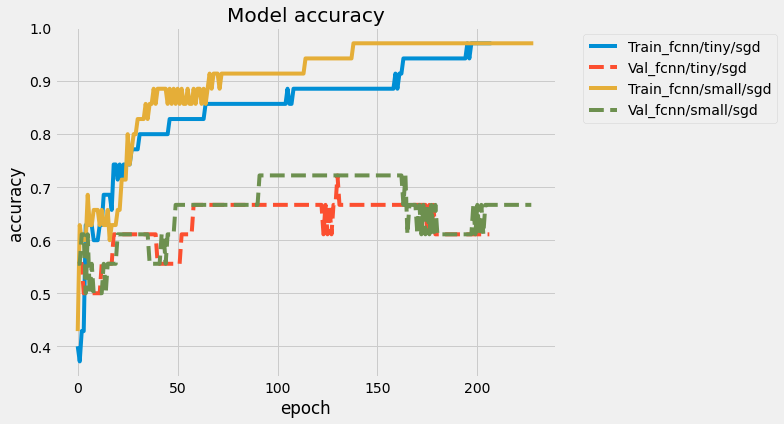

In [23]:
plot_report(size_histories)

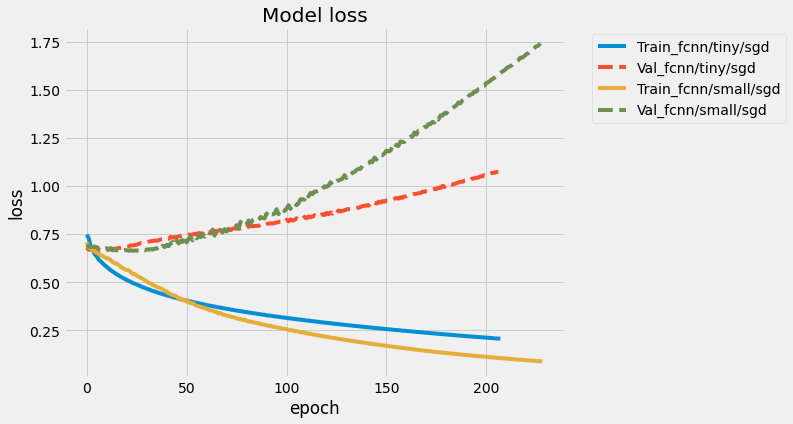

In [24]:
plot_report(size_histories, 'loss')

In [25]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu)(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu)(dense_1)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid)(dense_2)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid)(dense_3)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_histories['fcnn/large/sgd'] = compile_and_fit(model, train_dataset, 
                                              test_dataset,
                                              loss='binary_crossentropy',
                                              optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 263,665
Trainable params: 263,665
Non-trainable

In [26]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 2ms/step - loss: 0.1579 - accuracy: 0.9714
training loss : 0.15794643759727478
training accuracy : 0.9714285731315613
5/5 [==============================] - 0s 1ms/step - loss: 0.7895 - accuracy: 0.6667
test loss : 0.7894898653030396
test accuracy : 0.6666666865348816


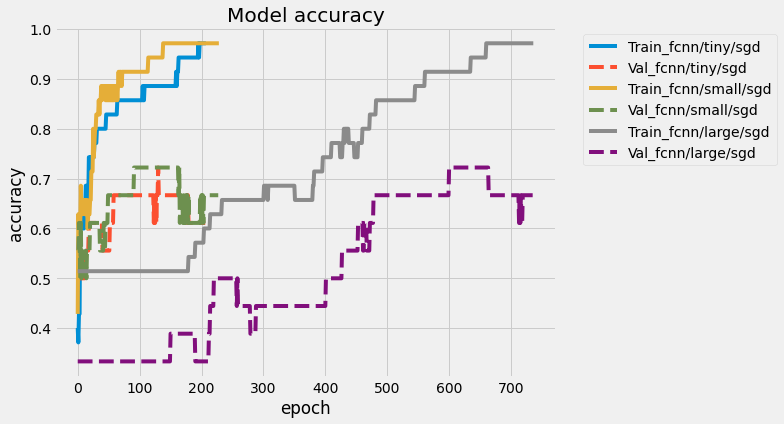

In [27]:
plot_report(size_histories)

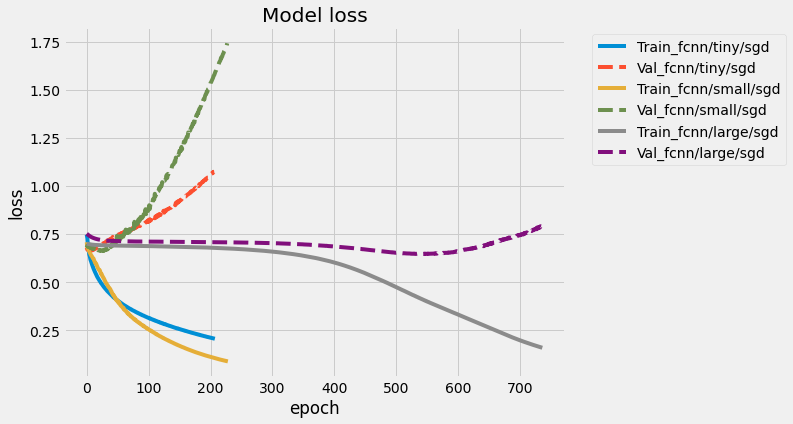

In [28]:
plot_report(size_histories, 'loss')

### Dropout

Although we got an accuracy of 0.75 looking at loss function chart is pretty obvious: There is overfiting. Now we have an overfitted NN let's make some adjustments to improve generalization capacity startin from dropout techniques.  

In [29]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu)(inputs)
dropout_1 = tf.keras.layers.Dropout(dr)(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu)(dropout_1)
dropout_2 = tf.keras.layers.Dropout(dr)(dense_2)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid)(dropout_2)
dropout_3 = tf.keras.layers.Dropout(dr)(dense_3)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid)(dropout_3)
dropout_4 = tf.keras.layers.Dropout(dr)(dense_4)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dropout_4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_histories['fcnn/large/dropout/sgd'] = compile_and_fit(model, 
                                                      train_dataset,
                                                      test_dataset,
                                                      optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                      max_epochs=num_epochs,
                                                      loss='binary_crossentropy')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                65552     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136   

In [30]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.5143
training loss : 0.6929263472557068
training accuracy : 0.5142857432365417
5/5 [==============================] - 0s 1ms/step - loss: 0.7116 - accuracy: 0.3333
test loss : 0.7115591168403625
test accuracy : 0.3333333432674408


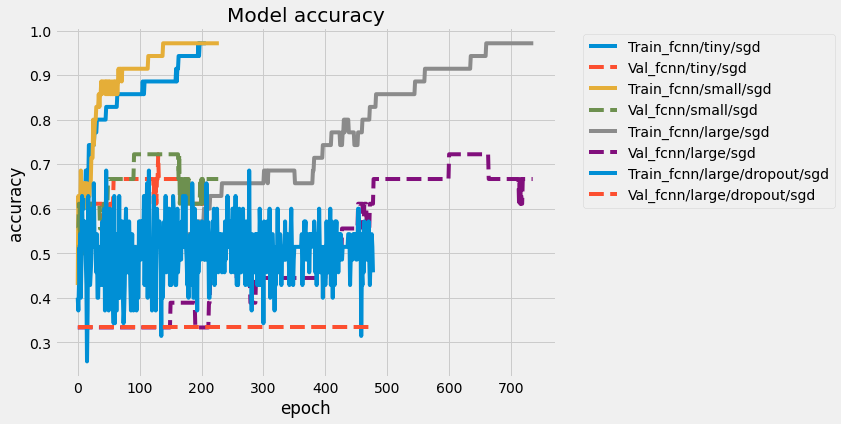

In [31]:
plot_report(size_histories)

Validation accuracy keeps improving more epoch with a total improvement from 0.75 to 0.81. Furthemore, the gap between training loss function and test loss function has been reduced.

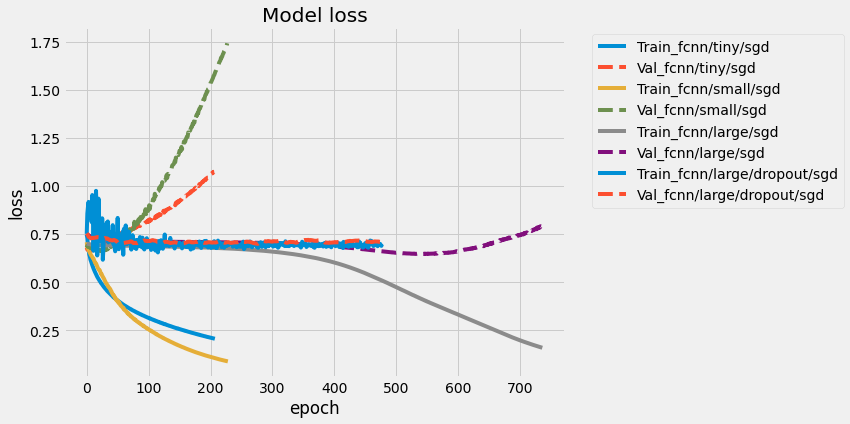

In [32]:
plot_report(size_histories, metric='loss')

### Kernel regularizer

In [33]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large/sgd']
regularizer_histories['dropout'] = size_histories['fcnn/large/dropout/sgd']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [34]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu,kernel_regularizer=regularizers.l1(lr1))(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu,kernel_regularizer=regularizers.l1(lr1))(dense_1)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu,kernel_regularizer=regularizers.l1(lr1))(dense_2)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.relu,kernel_regularizer=regularizers.l1(lr1))(dense_3)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

regularizer_histories['fcnn/large/l2/sgd'] = compile_and_fit(model, train_dataset, 
                                              test_dataset, 
                                              optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              loss="binary_crossentropy",
                                            max_epochs=num_epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 64)                262208    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 263,665
Trainable params: 263,665
Non-trainable

In [35]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

9/9 [==============================] - 0s 2ms/step - loss: 0.4863 - accuracy: 1.0000
training loss : 0.48627182841300964
training accuracy : 1.0
5/5 [==============================] - 0s 2ms/step - loss: 3.7585 - accuracy: 0.5556
test loss : 3.75852108001709
test accuracy : 0.5555555820465088


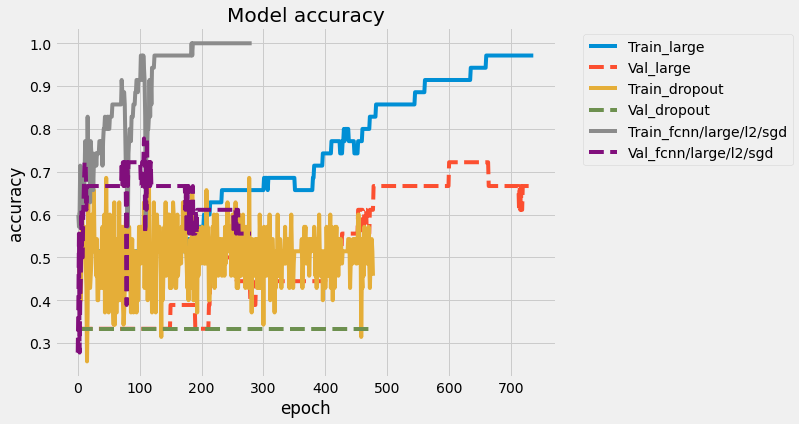

In [36]:
plot_report(regularizer_histories, 'accuracy')

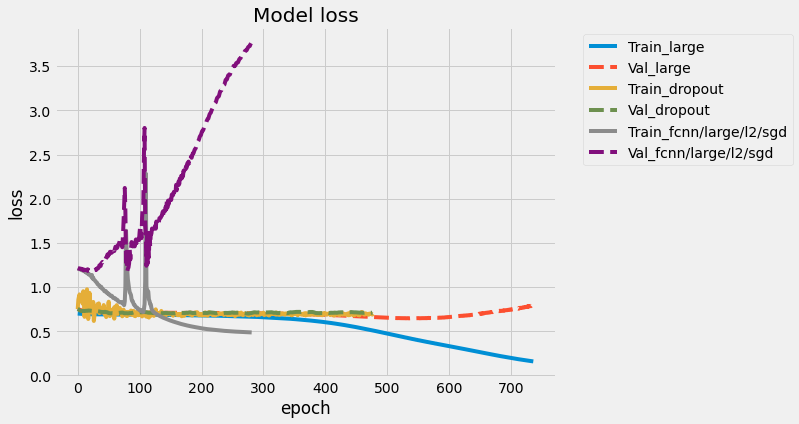

In [37]:
plot_report(regularizer_histories, 'loss')

Now let's see what happens combining both techniques

In [ ]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(inputs)
dropout_1 = tf.keras.layers.Dropout(dr)(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(dropout_1)
dropout_2 = tf.keras.layers.Dropout(dr)(dense_2)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(dropout_2)
dropout_3 = tf.keras.layers.Dropout(dr)(dense_3)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(dropout_3)
dropout_4 = tf.keras.layers.Dropout(dr)(dense_4)

dense_5 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(dropout_4)
dropout_5 = tf.keras.layers.Dropout(dr)(dense_5)
dense_6 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(dropout_5)
dropout_6 = tf.keras.layers.Dropout(dr)(dense_6)
dense_7 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(dropout_6)
dropout_7 = tf.keras.layers.Dropout(dr)(dense_7)
dense_8 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(dropout_7)
dropout_8 = tf.keras.layers.Dropout(dr)(dense_8)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dropout_8)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

regularizer_histories['fcnn/large/combined/sgd'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                65552     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136   

In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(regularizer_histories, 'accuracy')

In [ ]:
plot_report(regularizer_histories, 'loss')

## Batch Normalization

Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. It was proposed by Sergey Ioffe and Christian Szegedy in 2015.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


In [ ]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large/sgd']
batch_histories['dropout'] = size_histories['fcnn/large/dropout/sgd']

In [ ]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(inputs)
norm_1 = tf.keras.layers.BatchNormalization()(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(norm_1)
norm_2 = tf.keras.layers.BatchNormalization()(dense_2)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(norm_2)
norm_3 = tf.keras.layers.BatchNormalization()(dense_3)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(norm_3)
norm_4 = tf.keras.layers.BatchNormalization()(dense_4)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(norm_4)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

batch_histories['fcnn/small/batch/sgd'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)

In [ ]:
batch_histories['fcnn/small/batch/sgd'].history['accuracy'][-1], batch_histories['fcnn/small/batch/sgd'].history['val_accuracy'][-1]

In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(batch_histories, 'accuracy')

In [ ]:
plot_report(batch_histories, 'loss')

## LSTM-FCNN

Univariate time series classification model, the Long Short Term Memory Fully Convolutional Network (LSTM-FCN) to capture time related information

In [ ]:
lstm_histories = {}
lstm_histories['large'] = size_histories['fcnn/large/sgd']
lstm_histories['dropout'] = size_histories['fcnn/large/dropout/sgd']

In [ ]:
lambda_1 = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(inputs)# expand the dimension form (50, 4096) to (50, 4096, 1)
lstm_1 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False)(lambda_1)
dense_1 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(lstm_1)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

lstm_histories['lstm/tiny'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)

In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(lstm_histories, 'accuracy')

In [ ]:
plot_report(lstm_histories, 'loss')

In [ ]:
lstm_1 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True)(lambda_1)
lstm_2 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False)(lstm_1)

dense_1 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(lstm_2)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

lstm_histories['lstm/small'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)


In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(lstm_histories, 'accuracy')

In [ ]:
plot_report(lstm_histories, 'loss')

In [ ]:
lstm_1 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True)(lambda_1)
lstm_2 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False)(lstm_2)

dense_1 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(lstm_3)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

lstm_histories['lstm/large'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)

In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(lstm_histories, 'accuracy')

In [ ]:
plot_report(lstm_histories, 'loss')